# Lab | Random Forests
For this lab, you will be using the CSV files provided in the files_for_lab folder.

**Instructions**
- Apply the Random Forests algorithm but this time only by upscaling the data.
- Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?

In [71]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as unkind_squared_error, r2_score
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder

In [72]:
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [73]:
data.isna().sum().sum()

0

In [75]:
def classify_this(models, X_train, y_train, X_test, y_test, note, results):
    for m in models:
        model = m.fit(X_train,y_train)
        r_train = recall_score(y_train, model.predict(X_train))
        r_test = recall_score(y_test, model.predict(X_test))
        p_train = precision_score(y_train, model.predict(X_train))
        p_test = precision_score(y_test, model.predict(X_test))
        results.loc[len(results)] = [m, note, m.score(X_train, y_train), m.score(X_test, y_test), r_train, r_test, p_train, p_test, confusion_matrix(y_test, model.predict(X_test))]
    return results

In [184]:
numerical
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical)

In [185]:
from sklearn.feature_selection import VarianceThreshold 
var_threshold = 0.02
sel = VarianceThreshold(threshold=(var_threshold))

In [186]:
sel = sel.fit(numerical_scaled)
temp = sel.transform(numerical_scaled)
temp = pd.DataFrame(temp)
print(numerical_scaled.shape)
print(temp.shape)

(95412, 315)
(95412, 79)


In [195]:
var_list = list(sel.get_support())
list(zip(numerical.columns, var_list))
[col[0] for col in zip(numerical.columns, var_list) if col[1] == False]
removed_columns = pd.DataFrame(data=(numerical.columns,sel.variances_,sel.get_support()), index=('column_name','variance','statement')).T
columns_removed = removed_columns[['column_name']].loc[(removed_columns['statement'] == False),:]
columns_removed

,column_name
0,TCODE
4,HIT
5,MALEMILI
6,MALEVET
9,LOCALGOV
...,...
306,MINRAMNT
307,MAXRAMNT
308,LASTGIFT
309,TIMELAG


In [187]:
data = pd.concat([temp, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [188]:
y = data[['TARGET_B']]
X = data.drop(['TARGET_B', 'TARGET_D'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Upsampling

In [189]:
le_data = pd.concat([X_train, y_train],axis=1)

category_0 = le_data[le_data['TARGET_B'] == 0]
category_1 = le_data[le_data['TARGET_B'] == 1]

category_1_oversampled = resample(category_1, 
                                  replace=True, 
                                  n_samples = len(category_0))
data_upsampled = pd.concat([category_0, category_1_oversampled], axis=0)
data_upsampled = data_upsampled.sample(frac =1) #randomize the rows
data_upsampled = data_upsampled.reset_index(drop=True)
data_upsampled['TARGET_B'].value_counts()

1    72486
0    72486
Name: TARGET_B, dtype: int64

In [190]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20)
#clf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=5) = heavily overtrains model

models = [clf]

In [191]:
y = data_upsampled[['TARGET_B']]
X = data_upsampled.drop(['TARGET_B'], axis=1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
encoded_categorical = encoded_categorical.reset_index(drop=True)
encoded_categorical.columns = encoder.get_feature_names_out()
X = pd.concat([numericalX, encoded_categorical], axis = 1)

numericalX = X_test.select_dtypes(np.number)
categoricalX = X_test.select_dtypes(object)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
encoded_categorical = encoded_categorical.reset_index(drop=True)
encoded_categorical.columns = encoder.get_feature_names_out()
numericalX = numericalX.reset_index(drop=True)
X_test = pd.concat([numericalX, encoded_categorical], axis = 1)


In [192]:
clf.fit(X, np.ravel(y))
print(clf.score(X, np.ravel(y)))
print(clf.score(X_test, np.ravel(y_test)))

c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


0.6236376679634688
0.599329245925693


c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [193]:
results = pd.DataFrame(columns=['Model','Note','Train Accuracy','Test Accuracy', 'Train Recall', 'Test Recall', 'Train Precision', 'Test Precision','confusion_matrix'])
results = classify_this(models, X, np.ravel(y), X_test, y_test, "Upsampling",results)
results

c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature 

,Model,Note,Train Accuracy,Test Accuracy,Train Recall,Test Recall,Train Precision,Test Precision,confusion_matrix
0,"(DecisionTreeClassifier(max_depth=5, max_featu...",Upsampling,0.626928,0.595766,0.651008,0.568,0.621096,0.072357,"[[10801, 7282], [432, 568]]"


### Conclusion

*So we are getting a super low precision. The cost of this is directly related to an increased cost of sending out packs to people who likely will not respond.*

*However, for the current model the recall is good so we are at least largely capturing the majority of people who are more likely to respond positively.*

*I would think this would likely be the most desirable as we want to capture as many of potential donors as possible, that said we also need to consider price of sending out packages vs what we expect in return as donations to determine what the best balance would be - assuming a very low cost to sending out then we can live with a low precision and higher recall.*

In [11]:
targets.describe()

,TARGET_B,TARGET_D
count,95412.000000,95412.000000
mean,0.050759,0.793073
std,0.219506,4.429725
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,200.000000


In [12]:
targets[targets['TARGET_B']>0].shape

(4843, 2)

In [13]:
targets[targets['TARGET_D']>0].shape

(4843, 2)

In [14]:
targets[(targets['TARGET_D']>0)&(targets['TARGET_B']>0)].shape

(4843, 2)

## Lab | Final regression model in "Health Care for All" Case
**Instructions**

At this point, we have created a model to predict who will make a donation and who won't. But, what about the ammount of money that each person will give? In this lab, subset those that made a donation and use that subset to create a model to predict how much money will they give.

Evaluate the result of your model and estimate how much better the result are for the bussiness in comparison with the naive scenario we discuss on Monday.

In [136]:
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')
data = pd.concat([numerical, categorical, targets], axis = 1)
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [137]:
donors = data[data['TARGET_B']==1]

In [138]:
donors = donors.drop(['TARGET_B'], axis=1)

In [201]:
for c in columns_removed.values:
    donors = donors.drop(c, axis=1)

#### Encode

In [202]:
y = donors[['TARGET_D']]
X = donors.drop(['TARGET_D'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes(object)

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical = pd.DataFrame(encoded_categorical)
encoded_categorical = encoded_categorical.reset_index(drop=True)
numericalX = numericalX.reset_index(drop=True)
encoded_categorical.columns = encoder.get_feature_names_out()
X = pd.concat([numericalX, encoded_categorical], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Scale

In [203]:
# we've encoded the categoricals - so might as well scale ALL THE THINGS!

transformer = MinMaxScaler().fit(X_train)
X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)
    

#### Model Regression

In [204]:
def regress_this(models, X_train, y_train, X_test, y_test, note, results_reg):
    for m in models:
        model = m.fit(X_train,y_train)
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)         
        results_reg.loc[len(results_reg)] = [m, note, r2_score(y_train, predictions_train), r2_score(y_test, predictions_test), unkind_squared_error(y_test,predictions_test),  np.sqrt(unkind_squared_error(y_test,predictions_test)), predictions_test.mean()]
    return results_reg

In [205]:
# models with basically random parameters...
KNR = KNeighborsRegressor(n_neighbors=10)
lm = LinearRegression()
MLP = MLPRegressor()

models = [lm, KNR, MLP]

results_reg = pd.DataFrame(columns=['Model','Note','R2_Train','R2_Test', 'MSE', 'MAE', 'Avg Prediction on test'])
results_reg = regress_this(models, X_train, np.ravel(y_train), X_test, y_test, "done-nothin'", results_reg)

c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [179]:
import xgboost as xgb
xgbr = xgb.XGBRegressor(verbosity=0, max_depth = 9, min_child_weight = 1, alpha = 0.5, eta = 0.5, subsample = 1, cosample_bytree = 1, n_estimators = 1000, n_jobs = 10) 
models = [xgbr]
results_reg = regress_this(models, X_train, np.ravel(y_train), X_test, y_test, "XGBRegressor", results_reg)
results_reg

,Model,Note,R2_Train,R2_Test,MSE,MAE,Avg Prediction on test
0,LinearRegression(),done-nothin',0.609559,0.289553,135.386110,11.635554,15.986339
1,KNeighborsRegressor(n_neighbors=10),done-nothin',0.346013,0.221858,148.286332,12.177288,15.406828
2,MLPRegressor(),done-nothin',0.680545,0.344334,124.946789,11.177960,15.823504
3,LinearRegression(),PCA 0.8 Reduction',0.335726,0.312365,131.038970,11.447225,16.175619
4,KNeighborsRegressor(n_neighbors=10),PCA 0.8 Reduction',0.361988,0.225216,147.646508,12.150988,15.340252
5,MLPRegressor(),PCA 0.8 Reduction',0.540922,0.271665,138.795002,11.781129,16.242883
6,LinearRegression(),PCA 0.95 Reduction',0.406562,0.355326,122.852055,11.083865,16.342309
7,KNeighborsRegressor(n_neighbors=10),PCA 0.95 Reduction',0.355731,0.227948,147.125792,12.129542,15.375963
8,MLPRegressor(),PCA 0.95 Reduction',0.782431,0.241140,144.611837,12.025466,16.354974
9,"XGBRegressor(alpha=0.5, base_score=0.5, booste...",XGBRegressor,0.999999,0.268563,139.385989,11.806184,16.552183


In [206]:
results_reg

,Model,Note,R2_Train,R2_Test,MSE,MAE,Avg Prediction on test
0,LinearRegression(),done-nothin',0.402029,0.344993,124.821178,11.172340,16.290299
1,KNeighborsRegressor(n_neighbors=10),done-nothin',0.375055,0.244424,143.986101,11.999421,15.519140
2,MLPRegressor(),done-nothin',0.553345,0.312866,130.943449,11.443052,15.531825


In [144]:
true_positives = results.confusion_matrix.values[0][1,1]
false_positives = results.confusion_matrix.values[0][0,1]
package_count = true_positives + false_positives
package_cost = 0.68
total_package_cost = package_count * package_cost

top_reg = results_reg.sort_values(by=['MSE'], ascending=False).head(1)

avg_donation = top_reg['Avg Prediction on test'].values[0]
total_est_donations = avg_donation * true_positives

donations_profit = total_est_donations - avg_donation
profit_per_pack = donations_profit / package_count
roi = total_est_donations / total_package_cost

print('** If strictly people who have donated before **')
print('Total package cost:\t$' + str(round(total_package_cost,2)))
print('Total Est. Donations:\t$' + str(round(total_est_donations,2)))
print('Donations Total Profit:\t$' + str(round(donations_profit,2)))
if profit_per_pack > 0:
    print('Profit Per Package:\t+ $' + str(round(profit_per_pack,2)))
    print('Return on Investment:\t+ ' + str(round(roi,2)) + '%')
elif profit_per_pack < 0:
    print('Profit Per Package:\t- $' + str(abs(round(profit_per_pack,2))))
else:
    print('Profit Per Package:\t$' + str(round(profit_per_pack,2)))
    
print()
print()

package_count = true_positives + false_positives
package_cost = 0.68
total_package_cost = package_count * package_cost

top_reg = results_reg.sort_values(by=['MSE'], ascending=False).head(1)

avg_donation = top_reg['Avg Prediction on test'].values[0]
total_est_donations = avg_donation * (true_positives+false_positives)

donations_profit = total_est_donations - avg_donation
profit_per_pack = donations_profit / package_count
roi = total_est_donations / total_package_cost

print('** Including potential (true and false positives) **')
print('Total package cost:\t$' + str(round(total_package_cost,2)))
print('Total Est. Donations:\t$' + str(round(total_est_donations,2)))
print('Donations Total Profit:\t$' + str(round(donations_profit,2)))
if profit_per_pack > 0:
    print('Profit Per Package:\t+ $' + str(round(profit_per_pack,2)))
    print('Return on Investment:\t+ ' + str(round(roi,2)) + '%')
elif profit_per_pack < 0:
    print('Profit Per Package:\t- $' + str(abs(round(profit_per_pack,2))))
else:
    print('Profit Per Package:\t$' + str(round(profit_per_pack,2)))

** If strictly people who have donated before **
Total package cost:	$5209.48
Total Est. Donations:	$8375.38
Donations Total Profit:	$8359.98
Profit Per Package:	+ $1.09
Return on Investment:	+ 1.61%


** Including potential (true and false positives) **
Total package cost:	$5209.48
Total Est. Donations:	$117948.09
Donations Total Profit:	$117932.7
Profit Per Package:	+ $15.39
Return on Investment:	+ 22.64%


#### Things to try:

**Models**
- Hyper paramater selection for Random Forest
- Hyper paramater selection for regressors
- ?Cross validation?

**Features**
- Feature reduction
    - Filter redundant
    - Select optimal
- Dimensional Reduction
    - PCA

In [177]:
numerical

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,CARDGIFT,MINRAMNT,MAXRAMNT,LASTGIFT,TIMELAG,AVGGIFT,CONTROLN,HPHONE_D,RFA_2F,CLUSTER2
0,0,60.000000,5,9,0,0,39,34,18,10,...,14,5.0,12.0,10.0,4,7.741935,95515,0,4,39
1,1,46.000000,6,9,16,0,15,55,11,6,...,1,10.0,25.0,25.0,18,15.666667,148535,0,2,1
2,1,61.611649,3,1,2,0,20,29,33,6,...,14,2.0,16.0,5.0,12,7.481481,15078,1,4,60
3,0,70.000000,1,4,2,0,23,14,31,3,...,7,2.0,11.0,10.0,9,6.812500,172556,1,4,41
4,0,78.000000,3,2,60,1,28,9,53,26,...,8,3.0,15.0,15.0,14,6.864865,7112,1,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,1,61.611649,5,9,0,14,36,47,11,7,...,0,25.0,25.0,25.0,9,25.000000,184568,0,1,12
95408,1,48.000000,7,9,1,0,31,43,19,4,...,0,20.0,20.0,20.0,9,20.000000,122706,1,1,2
95409,1,60.000000,5,9,0,0,18,46,20,7,...,4,3.0,10.0,10.0,3,8.285714,189641,1,3,34
95410,0,58.000000,7,9,0,0,28,35,20,9,...,18,5.0,21.0,18.0,4,12.146341,4693,1,4,11


In [145]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

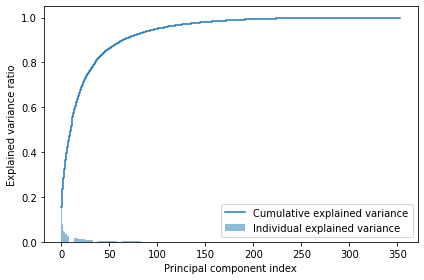

In [146]:
import numpy as np
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#cum_sum_eigenvalues
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, 
        alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, 
         where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [172]:
pca = PCA(0.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [164]:
pca.explained_variance_ratio_.sum()

0.8056626156052199

In [173]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [174]:
results_reg = regress_this(models, X_train_pca, np.ravel(y_train), X_test_pca, y_test, "PCA 0.95 Reduction'", results_reg)

c:\users\andy\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [175]:
results_reg

,Model,Note,R2_Train,R2_Test,MSE,MAE,Avg Prediction on test
0,LinearRegression(),done-nothin',0.609559,0.289553,135.386110,11.635554,15.986339
1,KNeighborsRegressor(n_neighbors=10),done-nothin',0.346013,0.221858,148.286332,12.177288,15.406828
2,MLPRegressor(),done-nothin',0.680545,0.344334,124.946789,11.177960,15.823504
3,LinearRegression(),PCA 0.8 Reduction',0.335726,0.312365,131.038970,11.447225,16.175619
4,KNeighborsRegressor(n_neighbors=10),PCA 0.8 Reduction',0.361988,0.225216,147.646508,12.150988,15.340252
5,MLPRegressor(),PCA 0.8 Reduction',0.540922,0.271665,138.795002,11.781129,16.242883
6,LinearRegression(),PCA 0.95 Reduction',0.406562,0.355326,122.852055,11.083865,16.342309
7,KNeighborsRegressor(n_neighbors=10),PCA 0.95 Reduction',0.355731,0.227948,147.125792,12.129542,15.375963
8,MLPRegressor(),PCA 0.95 Reduction',0.782431,0.241140,144.611837,12.025466,16.354974


In [161]:
results_reg = pd.DataFrame(columns=['Model','Note','R2_Train','R2_Test', 'MSE', 'MAE', 'Avg Prediction on test'])

for i in range(2,20):
    KNR = KNeighborsRegressor(n_neighbors=i)
    models = [KNR]   
    results_reg = regress_this(models, X_train_pca, np.ravel(y_train), X_test_pca, y_test, "PCA and K:" + str(i), results_reg)

In [162]:
results_reg

,Model,Note,R2_Train,R2_Test,MSE,MAE,Avg Prediction on test
0,KNeighborsRegressor(n_neighbors=2),PCA and K:2,0.671150,-0.076462,205.135648,14.322557,15.830537
1,KNeighborsRegressor(n_neighbors=3),PCA and K:3,0.564479,0.042614,182.443967,13.507182,15.605015
2,KNeighborsRegressor(n_neighbors=4),PCA and K:4,0.498487,0.102045,171.118476,13.081226,15.400808
3,KNeighborsRegressor(),PCA and K:5,0.456454,0.162856,159.530068,12.630521,15.411478
4,KNeighborsRegressor(n_neighbors=6),PCA and K:6,0.420141,0.213339,149.909868,12.243769,15.434800
5,KNeighborsRegressor(n_neighbors=7),PCA and K:7,0.397546,0.214348,149.717531,12.235912,15.338667
6,KNeighborsRegressor(n_neighbors=8),PCA and K:8,0.383055,0.221760,148.305058,12.178056,15.345863
7,KNeighborsRegressor(n_neighbors=9),PCA and K:9,0.367253,0.231703,146.410198,12.100008,15.327953
8,KNeighborsRegressor(n_neighbors=10),PCA and K:10,0.355436,0.241835,144.479413,12.019959,15.330117
9,KNeighborsRegressor(n_neighbors=11),PCA and K:11,0.347473,0.236180,145.557116,12.064705,15.348727
